## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = '/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully c

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_sqr (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Define ranges

In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 1000.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    # vapour pressure [Pa] - will be calculated from T_inf
    P_v = [par.P_v],
    # dynamic viscosity [Pa*s] - will be calculated from T_inf
    mu_L = [par.mu_L],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [1e5*x for x in [0.5, 4.0]], # pressure amplitude [Pa]
    freq = [5000.0, 150000.0], # frequency [Hz]
    n = [1.0]
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

In [4]:
# create folder for parameter study results:
save_path = '/home/yoda/Aron/parameter_studies/Excitation_search/sin_sqr_inverse'
file = gd.de.Make_dir(save_path)
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 30    # number os total searches
trial_points = 5000  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gd.rand_point(ranges, ID=i, padding=0.1),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_efficiency = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gd.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gd.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
            best_energy_efficiency = data.energy_efficiency
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gd.de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

 lsoda--  warning..internal t (=r1) and h (=r2) are  .95 [s]   |   R_E= 3.349636e-04;   p_A= 2.699895e+05;   freq= 4.071656e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  1862590469830481543168.0 [MJ/kg])                                                          
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
    

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .39 [s]   |   R_E= 5.779254e-04;   p_A= 1.961375e+05;   freq= 8.839288e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  1022782969337770803200.0 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .09 [s]   |   R_E= 5.585757e-04;   p_A= 2.486814e+05;   freq= 5.983251e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  168003628663988.1 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2944032924063D-01   r2 =  0.1552817582884D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2944032924063D-01   r2 =  0.1552817582884D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2944032924063D-01   r2 =  0.1552817582884D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .74 [s]   |   R_E= 8.920318e-04;   p_A= 1.250897e+05;   freq= 8.902206e+04;   |   NH3 production:  1.669001e+20 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3568875740125D-01   r2 =  0.3364264233475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3568875740125D-01   r2 =  0.3364264233475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3568875740125D-01   r2 =  0.3364264233475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .15 [s]   |   R_E= 2.509446e-04;   p_A= 1.798428e+05;   freq= 6.354891e+04;   |   NH3 production:  2.037860e+25 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1014758255581D+00   r2 =  0.6052931999212D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1014758255581D+00   r2 =  0.6052931999212D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1014758255581D+00   r2 =  0.6052931999212D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .53 [s]   |   R_E= 5.936973e-04;   p_A= 1.177488e+05;   freq= 7.090772e+04;   |   NH3 production:  2.430518e+22 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3892562234148D-01   r2 =  0.3222146439211D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3892562234148D-01   r2 =  0.3222146439211D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3892562234148D-01   r2 =  0.3222146439211D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .90 [s]   |   R_E= 5.936085e-04;   p_A= 2.486182e+05;   freq= 2.877945e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2182283687306D-01   r2 =  0.1694563364671D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2182283687306D-01   r2 =  0.1694563364671D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2182283687306D-01   r2 =  0.1694563364671D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .21 [s]   |   R_E= 6.588073e-04;   p_A= 2.576226e+05;   freq= 6.027200e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8628585658381D-01   r2 =  0.6907646091706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8628585658381D-01   r2 =  0.6907646091706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8628585658381D-01   r2 =  0.6907646091706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .28 [s]   |   R_E= 5.278217e-04;   p_A= 3.440752e+05;   freq= 4.405709e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421942381260D-01   r2 =  0.8392658218698D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421942381260D-01   r2 =  0.8392658218698D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421942381260D-01   r2 =  0.8392658218698D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .90 [s]   |   R_E= 1.849827e-04;   p_A= 1.533624e+05;   freq= 6.964738e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3947643475240D-01   r2 =  0.3218232225890D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3947643475240D-01   r2 =  0.3218232225890D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3947643475240D-01   r2 =  0.3218232225890D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .97 [s]   |   R_E= 2.015690e-04;   p_A= 3.120998e+05;   freq= 3.848764e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3174067185180D-01   r2 =  0.3420420591079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3174067185180D-01   r2 =  0.3420420591079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3174067185180D-01   r2 =  0.3420420591079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .32 [s]   |   R_E= 7.096746e-04;   p_A= 1.673616e+05;   freq= 7.968179e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .03 [s]   |   R_E= 8.997907e-04;   p_A= 2.778602e+05;   freq= 1.015479e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2563224488180D-01   r2 =  0.1528267893872D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2563224488180D-01   r2 =  0.1528267893872D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2563224488180D-01   r2 =  0.1528267893872D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .03 [s]   |   R_E= 4.907112e-04;   p_A= 2.490257e+05;   freq= 4.136840e+04;   |   NH3 production:  4.294783e+23 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3027588490860D-01   r2 =  0.1512585840116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3027588490860D-01   r2 =  0.1512585840116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3027588490860D-01   r2 =  0.1512585840116D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .24 [s]   |   R_E= 8.385800e-04;   p_A= 1.585658e+05;   freq= 4.956635e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5518658566017D+00   r2 =  0.4848992865562D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5518658566017D+00   r2 =  0.4848992865562D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5518658566017D+00   r2 =  0.4848992865562D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .63 [s]   |   R_E= 6.227163e-04;   p_A= 3.051065e+05;   freq= 9.635840e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4001798832193D+00   r2 =  0.2347942092881D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4001798832193D+00   r2 =  0.2347942092881D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4001798832193D+00   r2 =  0.2347942092881D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .02 [s]   |   R_E= 6.242447e-04;   p_A= 2.500544e+05;   freq= 1.229578e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  4000877120266.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476034686477D-03   r2 =  0.1215109789704D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476034686477D-03   r2 =  0.1215109789704D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476034686477D-03   r2 =  0.9772717393981D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in th

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .42 [s]   |   R_E= 6.601270e-04;   p_A= 1.997671e+05;   freq= 4.881671e+04;   |   NH3 production:  4.658206e+22 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3622089630750D+00   r2 =  0.2316779379699D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3622089630750D+00   r2 =  0.2316779379699D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3622089630750D+00   r2 =  0.2316779379699D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .37 [s]   |   R_E= 4.062315e-04;   p_A= 3.024788e+05;   freq= 2.445130e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .46 [s]   |   R_E= 3.319200e-04;   p_A= 2.971846e+05;   freq= 2.328982e+04;   |   NH3 production:  7.316788e+24 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9959011328170D-02   r2 =  0.7417557864478D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9959011328170D-02   r2 =  0.7417557864478D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9959011328170D-02   r2 =  0.7417557864478D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .99 [s]   |   R_E= 6.599905e-04;   p_A= 1.751609e+05;   freq= 4.395210e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3386370317252D-01   r2 =  0.3411914208196D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3386370317252D-01   r2 =  0.3411914208196D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3386370317252D-01   r2 =  0.3411914208196D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .80 [s]   |   R_E= 4.235164e-04;   p_A= 3.174090e+05;   freq= 6.260115e+04;   |   NH3 production:  1.924477e+24 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3442926417504D-01   r2 =  0.3240578155392D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3442926417504D-01   r2 =  0.3240578155392D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3442926417504D-01   r2 =  0.3240578155392D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .07 [s]   |   R_E= 5.375455e-04;   p_A= 2.136383e+05;   freq= 1.227707e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2623331678964D-01   r2 =  0.1567577929463D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2623331678964D-01   r2 =  0.1567577929463D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2623331678964D-01   r2 =  0.1567577929463D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .06 [s]   |   R_E= 3.711382e-04;   p_A= 2.249391e+05;   freq= 9.198716e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1193084013026D+00   r2 =  0.6005215892405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1193084013026D+00   r2 =  0.6005215892405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1193084013026D+00   r2 =  0.6005215892405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .61 [s]   |   R_E= 3.566497e-04;   p_A= 9.302406e+04;   freq= 6.143726e+04;   |   NH3 production:  5.024555e+23 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2597050490969D-01   r2 =  0.1617194585971D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2597050490969D-01   r2 =  0.1617194585971D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2597050490969D-01   r2 =  0.1617194585971D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .13 [s]   |   R_E= 5.346006e-04;   p_A= 2.819446e+05;   freq= 3.363632e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3917366342944D-01   r2 =  0.2862578406550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3917366342944D-01   r2 =  0.2862578406550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3917366342944D-01   r2 =  0.2862578406550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .58 [s]   |   R_E= 5.377587e-04;   p_A= 1.195262e+05;   freq= 2.825861e+04;   |   NH3 production:  4.779542e+24 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3275269698937D-01   r2 =  0.3451926867636D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3275269698937D-01   r2 =  0.3451926867636D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3275269698937D-01   r2 =  0.3451926867636D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .15 [s]   |   R_E= 2.603565e-04;   p_A= 1.013455e+05;   freq= 4.582574e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3547030114616D-01   r2 =  0.3444769977867D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3547030114616D-01   r2 =  0.3444769977867D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3547030114616D-01   r2 =  0.3444769977867D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .02 [s]   |   R_E= 8.473457e-04;   p_A= 1.486193e+05;   freq= 1.022751e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5446817901488D-01   r2 =  0.3272964437079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5446817901488D-01   r2 =  0.3272964437079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5446817901488D-01   r2 =  0.3272964437079D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .01 [s]   |   R_E= 4.628387e-04;   p_A= 2.824491e+05;   freq= 1.290539e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3560483864175D-01   r2 =  0.3210560764916D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3560483864175D-01   r2 =  0.3210560764916D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3560483864175D-01   r2 =  0.3210560764916D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .02 [s]   |   R_E= 6.870538e-04;   p_A= 2.402953e+05;   freq= 1.074734e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3489077112233D-01   r2 =  0.3463026883673D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3489077112233D-01   r2 =  0.3463026883673D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3489077112233D-01   r2 =  0.3463026883673D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .94 [s]   |   R_E= 2.432415e-04;   p_A= 3.196924e+05;   freq= 4.844105e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3378886108772D-01   r2 =  0.3235633300359D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3378886108772D-01   r2 =  0.3235633300359D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3378886108772D-01   r2 =  0.3235633300359D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .47 [s]   |   R_E= 7.014702e-04;   p_A= 3.269476e+05;   freq= 2.427309e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3202157287408D-01   r2 =  0.3350868989600D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3202157287408D-01   r2 =  0.3350868989600D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3202157287408D-01   r2 =  0.3350868989600D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .03 [s]   |   R_E= 3.711850e-04;   p_A= 1.024476e+05;   freq= 1.054509e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1141045215430D-01   r2 =  0.8325546830876D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1141045215430D-01   r2 =  0.8325546830876D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1141045215430D-01   r2 =  0.8325546830876D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .84 [s]   |   R_E= 8.689272e-04;   p_A= 9.023461e+04;   freq= 7.886416e+04;   |   NH3 production:  2.036251e+20 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2841199663097D-01   r2 =  0.1504773422967D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2841199663097D-01   r2 =  0.1504773422967D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2841199663097D-01   r2 =  0.1504773422967D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .02 [s]   |   R_E= 4.471125e-04;   p_A= 1.752046e+05;   freq= 1.097317e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3520925487058D-01   r2 =  0.3417784451763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3520925487058D-01   r2 =  0.3417784451763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3520925487058D-01   r2 =  0.3417784451763D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .28 [s]   |   R_E= 6.612574e-04;   p_A= 1.008922e+05;   freq= 1.206693e+05;   |   NH3 production: -1.397294e+12 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3246418526413D-01   r2 =  0.3450079179029D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3246418526413D-01   r2 =  0.3450079179029D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3246418526413D-01   r2 =  0.3450079179029D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .61 [s]   |   R_E= 7.718113e-04;   p_A= 2.920078e+05;   freq= 7.840564e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1336938736388D+00   r2 =  0.1228918810730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1336938736388D+00   r2 =  0.1228918810730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1336938736388D+00   r2 =  0.1228918810730D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .02 [s]   |   R_E= 7.021723e-04;   p_A= 1.281285e+05;   freq= 1.091258e+05;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1121931631901D+00   r2 =  0.6857523542629D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1121931631901D+00   r2 =  0.6857523542629D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1121931631901D+00   r2 =  0.6857523542629D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .76 [s]   |   R_E= 7.599453e-04;   p_A= 8.521705e+04;   freq= 3.962257e+04;   |   NH3 production:  4.679065e+22 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8164245517829D-02   r2 =  0.7430959782932D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8164245517829D-02   r2 =  0.7430959782932D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8164245517829D-02   r2 =  0.7430959782932D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .93 [s]   |   R_E= 5.913719e-04;   p_A= 1.258135e+05;   freq= 6.363756e+04;   |   NH3 production:  1.363277e+22 [MJ/kg] (best:  574362401674.9 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2691813492014D-01   r2 =  0.1510456745508D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2691813492014D-01   r2 =  0.1510456745508D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2691813492014D-01   r2 =  0.1510456745508D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .43 [s]   |   R_E= 4.443034e-04;   p_A= 2.585380e+05;   freq= 9.762510e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  260328656750.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3768576475337D-01   r2 =  0.3357256590475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3768576475337D-01   r2 =  0.3357256590475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3768576475337D-01   r2 =  0.3357256590475D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .37 [s]   |   R_E= 2.239929e-04;   p_A= 1.940349e+05;   freq= 2.532001e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  260328656750.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2114791854044D-01   r2 =  0.1468692077027D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2114791854044D-01   r2 =  0.1468692077027D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2114791854044D-01   r2 =  0.1468692077027D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .39 [s]   |   R_E= 5.829041e-04;   p_A= 3.358663e+05;   freq= 4.911813e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  260328656750.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3758241916068D-01   r2 =  0.3153996472035D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3758241916068D-01   r2 =  0.3153996472035D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3758241916068D-01   r2 =  0.3153996472035D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  .56 [s]   |   R_E= 2.117201e-04;   p_A= 3.533162e+05;   freq= 4.957659e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  260328656750.4 [MJ/kg])                                                 
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3021324705023D-01   r2 =  0.1568929561709D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3021324705023D-01   r2 =  0.1568929561709D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3021324705023D-01   r2 =  0.1568929561709D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


index:     4997/5000;   success: True;   runtime:   8.83 [s]   |   R_E= 7.067159e-04;   p_A= 1.580526e+05;   freq= 4.130142e+04;   |   NH3 production:  1.000000e+30 [MJ/kg] (best:  260328656750.4 [MJ/kg])                                                 
DONE
total time:  2558.44 [s]   ( 0.51 [s/run])


best energy_efficiency:  2.603287e+11 [MJ/kg]
30th energy_efficiency:  3.204379e+14 [MJ/kg]


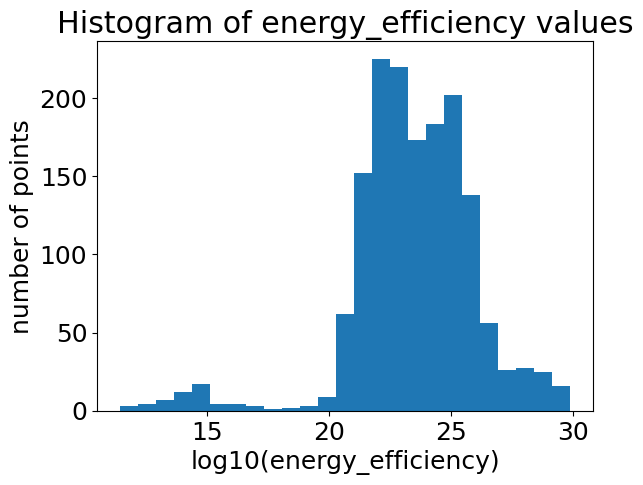

In [5]:

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_efficiency: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_efficiency: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_efficiency)')
plt.ylabel('number of points')
plt.title('Histogram of energy_efficiency values')
plt.show()

In [6]:
ranges2 = gd.de.copy(ranges)
for key in ranges:
    if len(ranges[key]) != 2:
        continue
    
    values = [point[key] for point in start_points[:searches]]
    ranges2[key][0] = min(values)
    ranges2[key][1] = max(values)
    print(f'old {key}: {ranges[key][1]-ranges[key][0]: e}')
    print(f'new {key}: {ranges2[key][1]-ranges2[key][0]: e}')

old R_E:  9.990000e-04
new R_E:  7.557432e-04
old p_A:  3.500000e+05
new p_A:  2.699496e+05
old freq:  1.450000e+05
new freq:  1.042363e+05


In [7]:
ranges2

{'R_E': [0.00012535771913421028, 0.0008811009355287021],
 'ratio': [1.0],
 'gases': [[11, 1]],
 'fractions': [[0.25, 0.75]],
 'P_amb': [101325.0],
 'T_inf': [303.15],
 'alfa_M': [0.35],
 'P_v': [2338.1],
 'mu_L': [0.001],
 'c_L': [1483.0],
 'surfactant': [1.0],
 'p_A': [86749.10166931825, 356698.6724201256],
 'freq': [25334.259064336627, 129570.5605940093],
 'n': [1.0]}

In [8]:
kwargs_list = [dict(
    ranges=ranges2,
    path=save_path,
    to_optimize=to_optimize,
    start_point=start_point,
    step_limit=200,
    max_step_until_decay=20,
    first_step=0.01,
    min_step=10e-5,
    decay=0.5,
    delta=1e-6,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for start_point in start_points[:searches]]

# Run gradient_search() multithread

In [9]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
gradient descent general settings:
    to_optimize = '{to_optimize}'   # key in data from de.get_data()
    searches = {searches}    # number os total searches
    trial_points = {trial_points}  # number of trial start_points. best ones will be used for searches

ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list[:searches]:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [10]:
"""Gradient descent, multithread"""

best_output = 1.0e30
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=1) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        last_data, best_outputs, elapsed = result
        num += 1
        to_plot.append(best_outputs)
        last_points.append(last_data)
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]
        
        # print stuff:
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps, finished in {elapsed: 8.2f} [s]   ({(elapsed / len(best_outputs)): 4.2f} [s/step]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / searches): .2f} [s/search])')

Folder already exists with 1 csv in it


	Error, gradient can not be calculated in point {'ID': 4426, 'R_E': 0.00025464965811325933, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 272498.58953638864, 'freq': 118822.29171383382, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4426, 'R_E': 0.0002508709420312869, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 272498.58953638864, 'freq': 118822.29171383382, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4426, 'R_E': 0.00024709222594931446, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 4458, 'R_E': 0.000265180826326344, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 107747.43625774956, 'freq': 118547.03679273026, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4458, 'R_E': 0.00026140211024437156, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 107747.43625774956, 'freq': 118547.03679273026, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4458, 'R_E': 0.00025762339416239913, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3537655998231D-01   r2 =  0.3263915960296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3537655998231D-01   r2 =  0.3263915960296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3537655998231D-01   r2 =  0.3263915960296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3537655998231D-01   r2 =  0.3263915960296D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3802142232290D-01   r2 =  0.3451424965653D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3802142232290D-01   r2 =  0.3451424965653D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3802142232290D-01   r2 =  0.3451424965653D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3802142232290D-01   r2 =  0.3451424965653D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1665, 'R_E': 0.0005808766979654374, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 301820.9808253644, 'freq': 116166.37645628717, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1665, 'R_E': 0.000577097981883465, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 301820.9808253644, 'freq': 116166.37645628717, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1665, 'R_E': 0.0005733192658014926, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 301820.9808253644, 'freq': 116166.37645628717, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1665, 'R_E': 0.0005695405497195201, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 301820.9808253644, 'freq': 116166.37645628717, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1665, 'R_E': 0.0005657618336375477, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 301820.9808253644, 'freq': 116166.37645628717, 'n': 1.0, 'output': 1e+30, 'success': True}
  8/30: Total 1   steps, finished in    92.66 [s]   ( 92.66 [s/step]).   Final energy_efficiency:  6673053986777.2 (best:  260328656750.4)
Folder already exists with 16 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3255161179520D-01   r2 =  0.3373612899931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3255161179520D-01   r2 =  0.3373612899931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3255161179520D-01   r2 =  0.3373612899931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3255161179520D-01   r2 =  0.3373612899931D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3440285689359D-01   r2 =  0.2873776372319D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3440285689359D-01   r2 =  0.2873776372319D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3440285689359D-01   r2 =  0.2873776372319D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3440285689359D-01   r2 =  0.2873776372319D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1888, 'R_E': 0.0007568476010390865, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100306.23897924545, 'freq': 113406.13543445486, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1888, 'R_E': 0.0007530688849571141, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100306.23897924545, 'freq': 113406.13543445486, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1888, 'R_E': 0.0007492901688751416, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1888, 'R_E': 0.0007455114527931692, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100306.23897924545, 'freq': 113406.13543445486, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 373, 'R_E': 0.0006299482206361763, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100107.89233733977, 'freq': 110862.27783655116, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 373, 'R_E': 0.0006261695045542039, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100107.89233733977, 'freq': 110862.27783655116, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 373, 'R_E': 0.0006223907884722314, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1807449269638D-01   r2 =  0.1461576645087D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006641660878733755, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3242467231211D-01   r2 =  0.3195263029300D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3242467231211D-01   r2 =  0.3195263029300D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3242467231211D-01   r2 =  0.3195263029300D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3242467231211D-01   r2 =  0.3195263029300D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1888, 'R_E': 0.0007417327367111968, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 100306.23897924545, 'freq': 113406.13543445486, 'n': 1.0, 'output': 1e+30, 'success': True}
 10/30: Total 1   steps, finished in   182.49 [s]   ( 182.49 [s/step]).   Final energy_efficiency:  27345147778151.1 (best:  260328656750.4)
Folder already exists with 18 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421942381260D-01   r2 =  0.8392658218698D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421942381260D-01 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8813556399383D-01   r2 =  0.6907929719931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8813556399383D-01   r2 =  0.6907929719931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8813556399383D-01   r2 =  0.6907929719931D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8813556399383D-01   r2 =  0.6907929719931D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1706078075498D-01   r2 =  0.1467086151015D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 230, 'R_E': 0.00015280292891076177, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 104067.7883583206, 'freq': 126772.53503074002, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2389266530237D+00   r2 =  0.1206466745691D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2389266530237D+00   r2 =  0.1206466745691D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2389266530237D+00   r2 =  0.1206466745691D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2389266530237D+00   r2 =  0.1206466745691D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 230, 'R_E': 0.00015091357086977552, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 104067.7883583206, 'freq': 126772.53503074002, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5617473070452D-01   r2 =  0.3450265215430D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5617473070452D-01   r2 =  0.3450265215430D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5617473070452D-01   r2 =  0.3450265215430D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5617473070452D-01   r2 =  0.3450265215430D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006584980137504168, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006566086557094306, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006556639766889375, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2025, 'R_E': 0.0006604894281993397, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 321533.0700803738, 'freq': 126867.86590791272, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3235051292499D-01   r2 =  0.3181686642706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3235051292499D-01   r2 =  0.3181686642706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3235051292499D-01   r2 =  0.3181686642706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3235051292499D-01   r2 =  0.3181686642706D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1840477428683D+00   r2 =  0.1224837104817D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2025, 'R_E': 0.0006586000701583535, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 321533.0700803738, 'freq': 126867.86590791272, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006561363161991841, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 2902, 'R_E': 0.0006556639766889375, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 133898.9294441189, 'freq': 129570.5605940093, 'n': 1.0, 'output': 1e+30, 'success': True}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3660942974950D-01   r2 =  0.2881634397984D-17
 lsoda--  warning..internal t (=r

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3660942974950D-01   r2 =  0.2881634397984D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3660942974950D-01   r2 =  0.2881634397984D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3660942974950D-01   r2 =  0.2881634397984D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3660942974950D-01   r2 =  0.2881634397984D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3197795238329D-01   r2 =  0.3182840588045D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3197795238329D-01   r2 =  0.3182840588045D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3197795238329D-01   r2 =  0.3182840588045D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3197795238329D-01   r2 =  0.3182840588045D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 11/30: Total 7   steps, finished in   397.63 [s]   ( 56.80 [s/step]).   Final energy_efficiency:  72591204726068859633664.0 (best:  260328656750.4)
Folder already exists with 19 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3292148063807D-01   r2 =  0.3188612473960D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3292148063807D-01   r2 =  0.3188612473960D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3292148063807D-01   r2 =  0.3188612473960D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3292148063807D-01   r2 =  0.3188612473960D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3224700445086D-01   r2 =  0.3183578158260D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3224700445086D-01   r2 =  0.3183578158260D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3224700445086D-01   r2 =  0.3183578158260D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3224700445086D-01   r2 =  0.3183578158260D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 13/30: Total 7   steps, finished in   437.68 [s]   ( 62.53 [s/step]).   Final energy_efficiency:  131283204813680185180160.0 (best:  260328656750.4)
Folder already exists with 21 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1945903966708D-02   r2 =  0.1069176862725D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4567648652764D-02   r2 =  0.3791874778991D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 14/30: Total 9   steps, finished in   600.56 [s]   ( 66.73 [s/step]).   Final energy_efficiency:  140709034183172528.0 (best:  260328656750.4)
Folder already exists with 22 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1955103842669D-02   r2 =  0.2145363507979D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1955103842669D-02   r2 =  0.2145363507979D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1955103842669D-02   r2 =  0.2145363507979D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1955103842669D-02   r2 =  0.2145363507979D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 15/30: Total 8   steps, finished in   183.33 [s]   ( 22.92 [s/step]).   Final energy_efficiency:  775374152507940677877760.0 (best:  260328656750.4)
Folder already exists with 23 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4474289539838D+00   r2 =  0.2634818223616D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2323, 'R_E': 0.0006648952596645794, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 352383.7820057249, 'freq': 114348.63576446376, 'n': 1.0, 'output': 1e+30, 'success': True}

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.



	Error, gradient can not be calculated in point {'ID': 2323, 'R_E': 0.000661116543582607, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 352383.7820057249, 'freq': 114348.63576446376, 'n': 1.0, 'output': 1e+30, 'success': True}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3465941882789D-01   r2 =  0.3239630213846D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3465941882789D-01   r2 =  0.3239630213846D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will co

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 17/30: Total 7   steps, finished in   667.39 [s]   ( 95.34 [s/step]).   Final energy_efficiency:  8505642608491056668931522560.0 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


Folder already exists with 25 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2323, 'R_E': 0.0006556846392147716, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 352383.7820057249, 'freq': 114348.63576446376, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3397679441658D-01   r2 =  0.3330064038660D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3397679441658D-01   r2 =  0.3330064038660D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3397679441658D-01   r2 =  0.3330064038660D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3397679441658D-01   r2 =  0.3330064038660D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 230, 'R_E': 0.0001524486742780768, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 104067.7883583206, 'freq': 126772.53503074002, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 230, 'R_E': 0.00015233058940051516, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 104067.7883583206, 'freq': 126772.53503074002, 'n': 1.0, 'output': 1e+30, 'success': True}
 18/30: Total 7   steps, finished in   698.46 [s]   ( 99.78 [s/step]).   Final energy_efficiency:  3912795237246660.5 (best:  260328656750.4)
Folder already exists with 26 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3449657290904D-01   r2 =  0.3405053948496D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3449657290904D-01   r2 =  0.3405053948496D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3449657290904D-01   r2 =  0.3405053948496D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3449657290904D-01   r2 =  0.3405053948496D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 2025, 'R_E': 0.000656120287729559, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 321533.0700803738, 'freq': 126867.86590791272, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3389416788607D-01   r2 =  0.3346702348997D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 4677, 'R_E': 0.0007995621558542219, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 219423.3494916637, 'freq': 104314.47716664494, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4677, 'R_E': 0.0007976727978132356, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 219423.3494916637, 'freq': 104314.47716664494, 'n': 1.0, 'output': 1e+30, 'success': True}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9005714614413D+00   r2 =  0.4626415361350D-16
 lsoda--  warning..internal t (

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3623109028203D-01   r2 =  0.3459858252148D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 20/30: Total 7   steps, finished in   274.37 [s]   ( 39.20 [s/step]).   Final energy_efficiency:  27131793852909.4 (best:  260328656750.4)
Folder already exists with 28 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3300978344801D-01   r2 =  0.3361117996933D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3300978344801D-01   r2 =  0.3361117996933D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3300978344801D-01   r2 =  0.3361117996933D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3300978344801D-01   r2 =  0.3361117996933D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


Folder already exists with 29 csv in it
	Error, gradient can not be calculated in point {'ID': 4053, 'R_E': 0.0004380326080735356, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 248862.9558214138, 'freq': 119443.89970171104, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4053, 'R_E': 0.0004342538919915632, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 248862.9558214138, 'freq': 119443.89970171104, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 4053, 'R_E': 0.00043047517590959075, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001,

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5076800699942D+00   r2 =  0.5011052980076D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9112437545913D+00   r2 =  0.4919342190271D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9112437545913D+00   r2 =  0.4919342190271D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9112437545913D+00   r2 =  0.4919342190271D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9112437545913D+00   r2 =  0.4919342190271D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 23/30: Total 9   steps, finished in    49.58 [s]   ( 5.51 [s/step]).   Final energy_efficiency:  16473367957898235098431488.0 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2730664227628D-01   r2 =  0.1616091502006D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2730664227628D-01   r2 =  0.1616091502006D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2730664227628D-01   r2 =  0.1616091502006D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2730664227628D-01   r2 =  0.1616091502006D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 24/30: Total 8   steps, finished in   939.01 [s]   ( 117.38 [s/step]).   Final energy_efficiency:  8376923569171.2 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3373263774092D-01   r2 =  0.3361499351225D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1013, 'R_E': 0.0006723120696509921, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 318625.5713226495, 'freq': 119379.23597682461, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3578257845974D-01   r2 =  0.3224480412209D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3578257845974D-01   r2 =  0.3224480412209D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3578257845974D-01   r2 =  0.3224480412209D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3578257845974D-01   r2 =  0.3224480412209D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3372431465073D-01   r2 =  0.3447667541689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3372431465073D-01   r2 =  0.3447667541689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3372431465073D-01   r2 =  0.3447667541689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3372431465073D-01   r2 =  0.3447667541689D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3311713989266D-01   r2 =  0.2865323709366D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3273848035696D-01   r2 =  0.3185640359330D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3273848035696D-01   r2 =  0.3185640359330D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3273848035696D-01   r2 =  0.3185640359330D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3273848035696D-01   r2 =  0.3185640359330D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2930100397348D-01   r2 =  0.1595327239301D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3417747919405D-01   r2 =  0.2892211645865D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3310931009349D-01   r2 =  0.2865196200137D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3310931009349D-01   r2 =  0.2865196200137D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3310931009349D-01   r2 =  0.2865196200137D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3310931009349D-01   r2 =  0.2865196200137D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 26/30: Total 8   steps, finished in   479.97 [s]   ( 60.00 [s/step]).   Final energy_efficiency:  6708933733974822.0 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3398017439184D+00   r2 =  0.2371431871306D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3524766505800D-01   r2 =  0.3226692333572D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3524766505800D-01   r2 =  0.3226692333572D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3524766505800D-01   r2 =  0.3226692333572D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3524766505800D-01   r2 =  0.3226692333572D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 27/30: Total 10  steps, finished in   375.60 [s]   ( 37.56 [s/step]).   Final energy_efficiency:  2439604889892256481280.0 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3654347803553D-01   r2 =  0.3372353738218D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3654347803553D-01   r2 =  0.3372353738218D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3654347803553D-01   r2 =  0.3372353738218D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3654347803553D-01   r2 =  0.3372353738218D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 4808, 'R_E': 0.0008719501647815913, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 259053.0483271617, 'freq': 82873.23575317537, 'n': 1.0, 'output': 1e+30, 'success': True}
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will con

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3285591128070D-01   r2 =  0.3407176645450D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3358660702050D-01   r2 =  0.3255809483491D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3358660702050D-01   r2 =  0.3255809483491D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3358660702050D-01   r2 =  0.3255809483491D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3358660702050D-01   r2 =  0.3255809483491D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3346726816467D-01   r2 =  0.3407087977753D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3346726816467D-01   r2 =  0.3407087977753D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3346726816467D-01   r2 =  0.3407087977753D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3346726816467D-01   r2 =  0.3407087977753D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3249418365789D-01   r2 =  0.3363707011444D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3249418365789D-01   r2 =  0.3363707011444D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3249418365789D-01   r2 =  0.3363707011444D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3249418365789D-01   r2 =  0.3363707011444D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 28/30: Total 7   steps, finished in   769.98 [s]   ( 110.00 [s/step]).   Final energy_efficiency:  5287640303057276764160.0 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3469242309904D-01   r2 =  0.3407261255074D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3469242309904D-01   r2 =  0.3407261255074D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3469242309904D-01   r2 =  0.3407261255074D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3469242309904D-01   r2 =  0.3407261255074D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 29/30: Total 8   steps, finished in   765.19 [s]   ( 95.65 [s/step]).   Final energy_efficiency:  66011224926724.7 (best:  260328656750.4)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1013, 'R_E': 0.0006712493057529375, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 318625.5713226495, 'freq': 119379.23597682461, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1013, 'R_E': 0.0006711312208753759, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 318625.5713226495, 'freq': 119379.23597682461, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


	Error, gradient can not be calculated in point {'ID': 1013, 'R_E': 0.0006710131359978143, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 318625.5713226495, 'freq': 119379.23597682461, 'n': 1.0, 'output': 1e+30, 'success': True}
	Error, gradient can not be calculated in point {'ID': 1013, 'R_E': 0.0006708950511202527, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'P_v': 2338.1, 'mu_L': 0.001, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': 318625.5713226495, 'freq': 119379.23597682461, 'n': 1.0, 'output': 1e+30, 'success': True}


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 30/30: Total 9   steps, finished in  1405.99 [s]   ( 156.22 [s/step]).   Final energy_efficiency:  112142213491396.8 (best:  260328656750.4)


DONE
total time:  0 hours  35 mins
             2091.44 [s]   ( 69.71 [s/search])


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


## Plot results

In [14]:
[(len(x), x[-1]) for x in to_plot if x[-1]<1e15]

[(1, 260328656750.4158),
 (1, 574362401674.9109),
 (1, 30594242910012.137),
 (1, 486131011239.6587),
 (1, 6673053986777.21),
 (1, 42163390878945.125),
 (1, 27345147778151.133),
 (7, 27131793852909.418),
 (9, 93943619560516.4),
 (1, 319456251528435.56),
 (8, 8376923569171.239),
 (8, 66011224926724.66),
 (9, 112142213491396.83)]

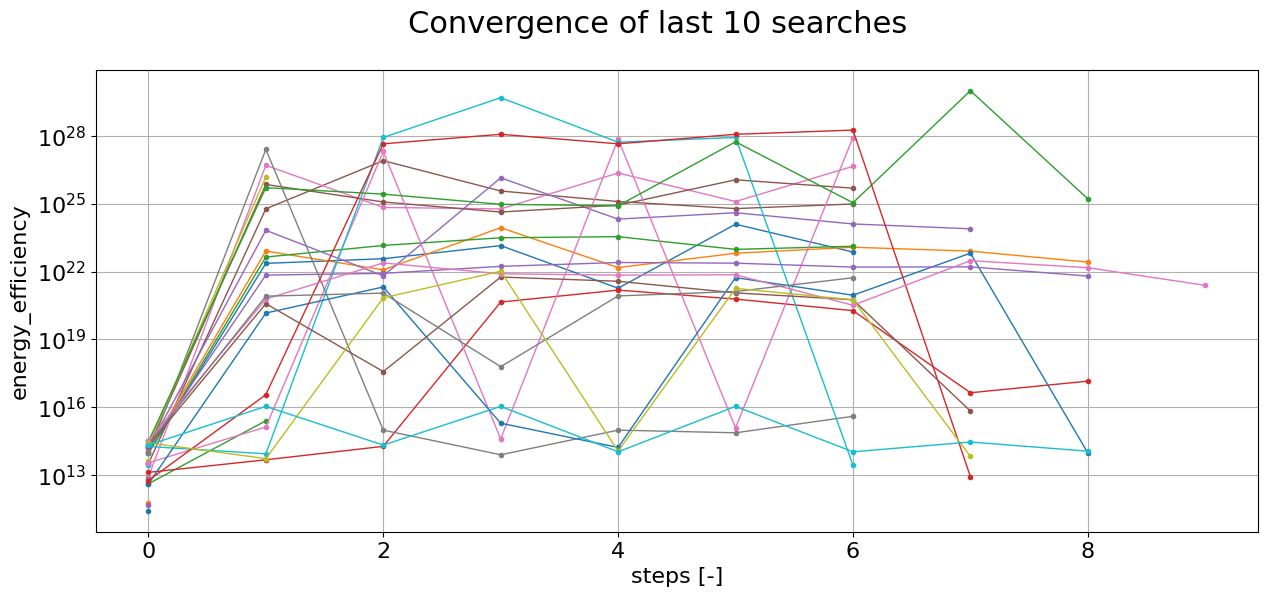

In [16]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
#ax.set_ylim(0.99*best_output, 1.15*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

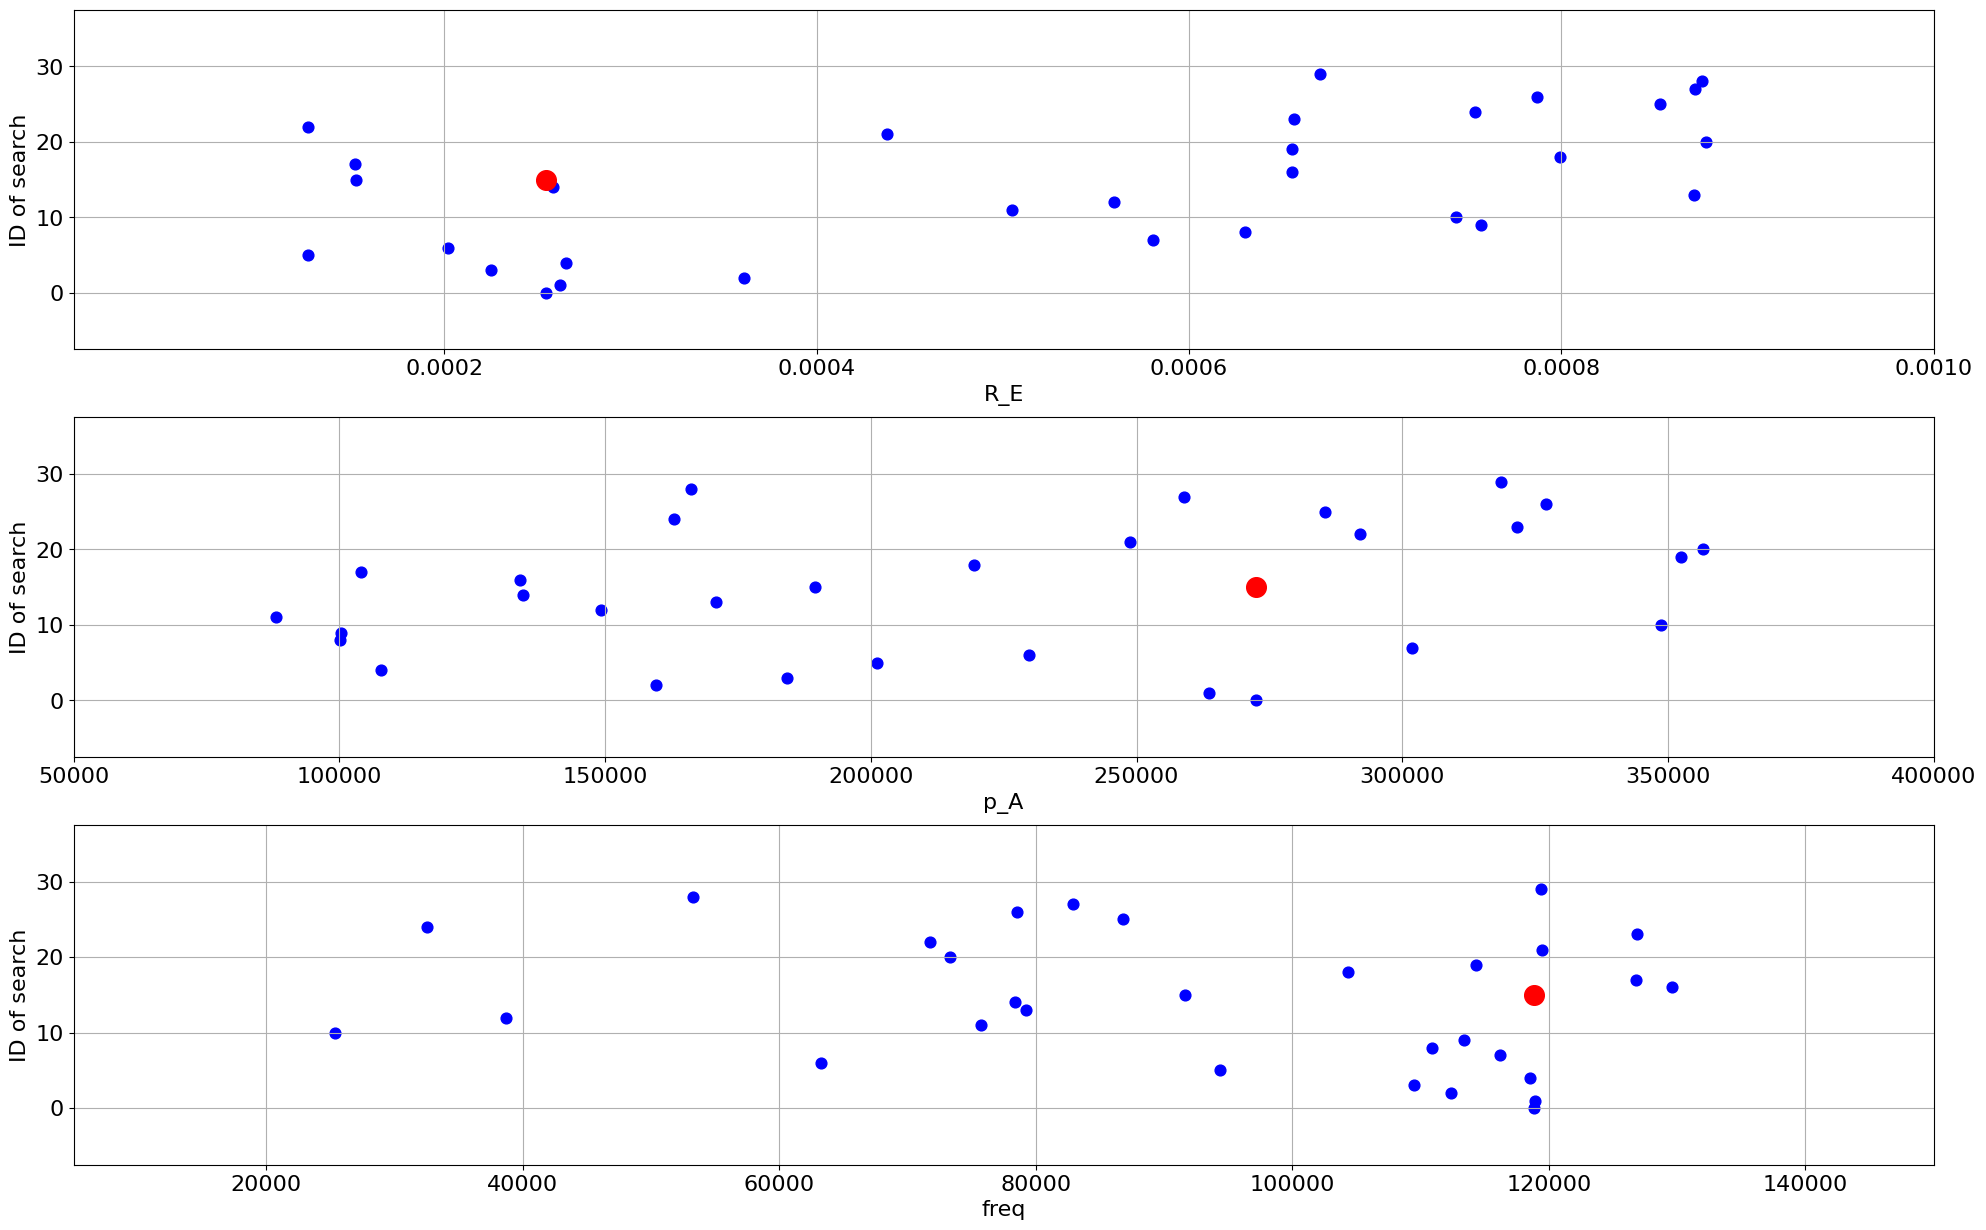

In [17]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
